In [1]:
from pathlib import Path
import sys
sys.path.append("../..")
from neuralhydrology.datasetzoo import camusto
import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config


data_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\clean")

df = camusto.load_timeseries(data_dir=data_dir, basin="HY018",forcing="camusto_1h")

repo_path = Path(r"C:\Users\everett\Documents\GitHub")  # Replace with the actual path to the optswmm repository
sys.path.append(str(repo_path))
from camus_to.src.performance import Performance

output_path = Path(r"G:\My Drive\02_phd\00_conferences\2025-05 EGU\figs")
output_path.mkdir(parents=True, exist_ok=True)
plt.rcParams.update({'font.size': 18, 'axes.labelsize': 20, 'axes.titlesize': 22})


Dataset class 'camels_us' successfully added.
Dataset class 'camels_gb' successfully added.
Dataset class 'camels_aus' successfully added.
Dataset class 'camels_br' successfully added.
Dataset class 'hourly_camels_us' successfully added.
Dataset class 'camels_cl' successfully added.
Dataset class 'generic' successfully added.
Dataset class 'lamah_a' successfully added.
Dataset class 'lamah_b' successfully added.
Dataset class 'lamah_c' successfully added.
Dataset class 'caravan' successfully added.
Dataset class 'hysets' successfully added.
Dataset class 'camusto' successfully added.


In [36]:
tag = "ar_"
runs = [d for d in Path("runs").iterdir() if tag in d.name]

all_results = {run_dir: [] for run_dir in runs}
for run_dir in runs:
    try:
        print(run_dir)
        run_dir = Path(run_dir)
        # Load the model and test it
        tester = get_tester(cfg=cfg, run_dir=run_dir, period="train", init_model=True)

        cfg = Config(run_dir / "config.yml")
        results = tester.evaluate(save_results=True, metrics=cfg.metrics)

        perf = {key: {} for key in list(results.keys())}

        for key in results.keys():
            if "mts" in tag:
                obs = results[key]["1h"]["xr"]["discharge(mm)_camusto_1h_obs"]
                sim = results[key]["1h"]["xr"]["discharge(mm)_camusto_1h_sim"]
            else:
                obs = results[key]["1h"]["xr"]["discharge(mm)_obs"]
                sim = results[key]["1h"]["xr"]["discharge(mm)_sim"]
            obs = obs.values.flatten()
            sim = sim.values.flatten()
            # Calculate the performance metrics
            performance = Performance(obs, sim)

            for param in ["kge","nse","false_negative_rate","true_negative_rate","mse"]:
                out = getattr(performance, param)()
                perf[key][param] = out
        all_results[run_dir] = perf
    except:
        continue






c:\Users\everett\Documents\GitHub\neuralhydrology\examples\04-Multi-Timescale\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

runs\ar_ex1_1404_042511
runs\ar_ex1_1404_090048
# Evaluation: 100%|██████████| 33/33 [26:20<00:00, 47.89s/it]


In [35]:

key = "HY017"
#run_dir = Path('runs/mts_ex6_1504_182145')
run_dir = Path("runs/ar_ex1_1404_090048")
cfg = Config(run_dir / "config.yml")
tester = get_tester(cfg=cfg, run_dir=run_dir, period="train", init_model=True)
results = tester.evaluate(save_results=True, metrics=cfg.metrics)



c:\Users\everett\Documents\GitHub\neuralhydrology\examples\04-Multi-Timescale\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

# Evaluation: 100%|██████████| 33/33 [22:58<00:00, 41.77s/it]


<Axes: >

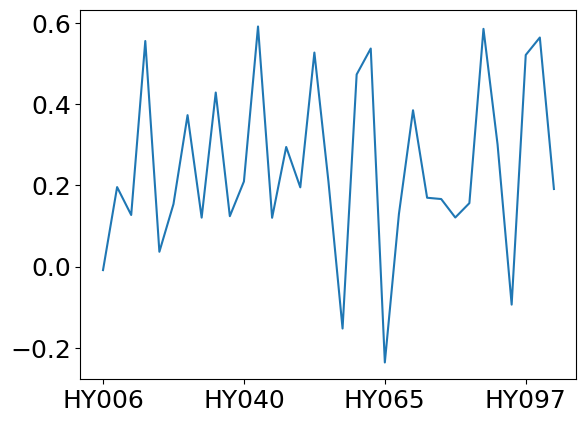

In [25]:
import pandas as pd
tag = "mts"
perf = {key: {} for key in list(results.keys())}
for key in results.keys():
    if tag == "mts":
        obs = results[key]["1h"]["xr"]["discharge(mm)_camusto_1h_obs"]
        sim = results[key]["1h"]["xr"]["discharge(mm)_camusto_1h_sim"]
    else:
        obs = results[key]["1h"]["xr"]["discharge(mm)_obs"]
        sim = results[key]["1h"]["xr"]["discharge(mm)_sim"]
    obs = obs.values.flatten()
    sim = sim.values.flatten()

    # Calculate the performance metrics
    performance = Performance(obs, sim)

    for param in ["kge","nse","false_negative_rate","true_negative_rate","mse", "rmse", "mae", "pve", "mse_hf"]:
        out = getattr(performance, param)()
        perf[key][param] = out

perfdf = pd.DataFrame.from_dict(perf, orient="index")
perfdf["kge"].plot()

#perfdf.to_csv(run_dir / "custom_test_results.csv")


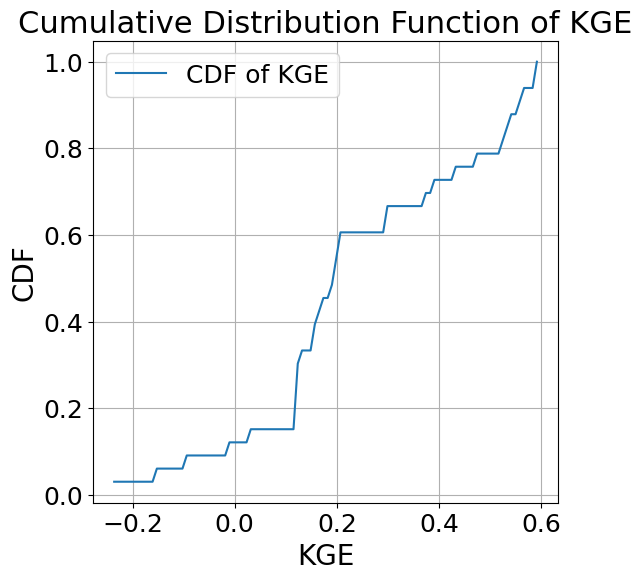

In [26]:
from scipy.stats import cumfreq
import numpy as np

# Extract the kge values
kge_values = perfdf['kge'].values

# Compute the cumulative frequency
res = cumfreq(kge_values, numbins=100, defaultreallimits=(np.min(kge_values), np.max(kge_values)))

# Generate the x-axis values for the CDF
x = res.lowerlimit + np.linspace(0, res.binsize * res.cumcount.size, res.cumcount.size)

# Plot the CDF
plt.figure(figsize=(6, 6))
plt.plot(x, res.cumcount / res.cumcount[-1], label='CDF of KGE')
plt.xlabel('KGE')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of KGE')
plt.grid()
plt.legend()
plt.show()

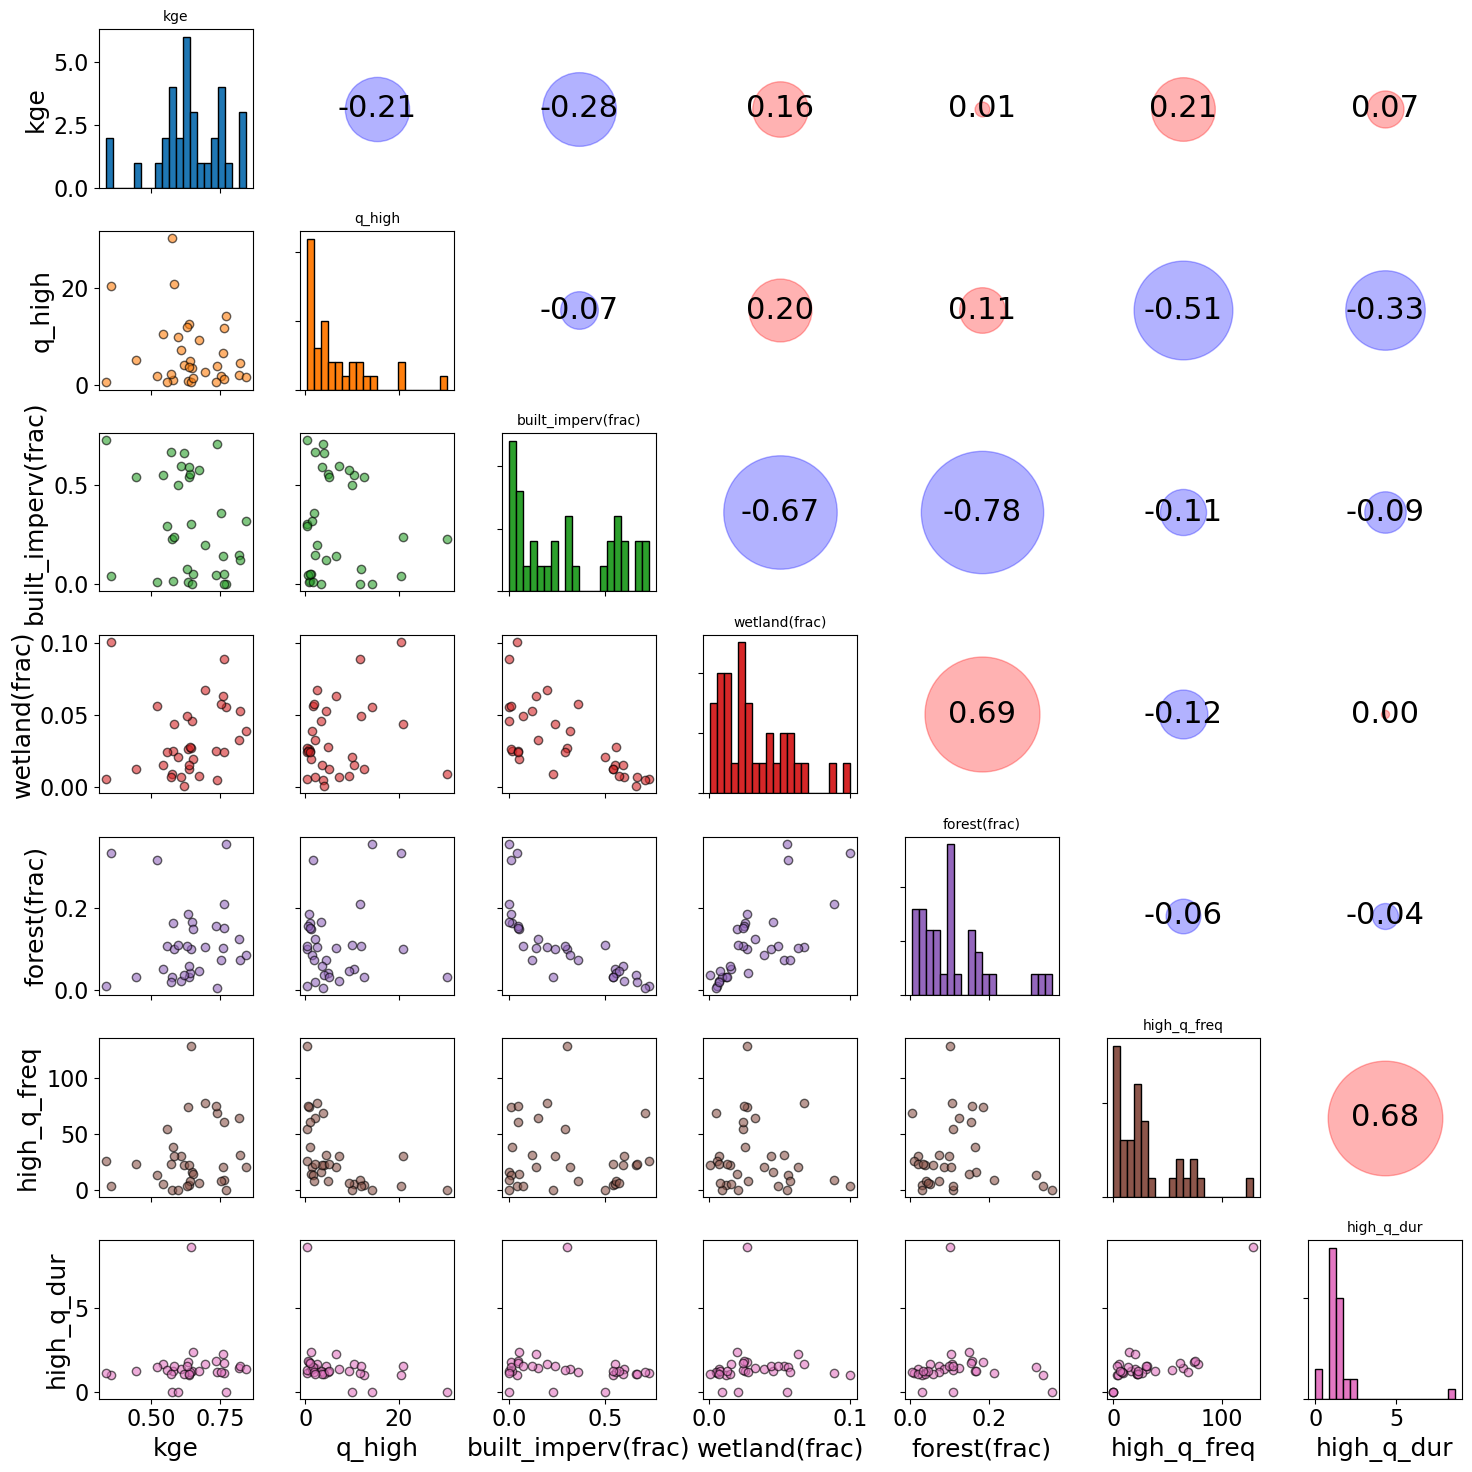

In [119]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.plotting import scatter_matrix


boundaries = gpd.read_file(Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\clean\boundaries.csv")).set_index("TRCAID")
boundaries["geometry"] = gpd.GeoSeries.from_wkt(boundaries["geometry"])
attributes = camusto.load_attributes(data_dir=data_dir)

basins = gpd.GeoDataFrame(boundaries.join(attributes, how="inner"))


df = perfdf.join(basins, how="inner")

# Create a correlogram (correlation heatmap)
cols = ["kge", "q_high","built_imperv(frac)","wetland(frac)","forest(frac)","high_q_freq","high_q_dur",]

correlation_matrix = df[cols].corr()

# Create a figure for the scatterplot matrix and correlation scores
fig, axes = plt.subplots(nrows=len(cols), ncols=len(cols), figsize=(15, 15))

colors = plt.cm.tab10.colors  # Use a colormap for different colors
for i, row in enumerate(cols):
    for j, col in enumerate(cols):
        if i == j:
            # Diagonal: Show histogram
            axes[i, j].hist(df[col], bins=20, color=colors[i % len(colors)], edgecolor='black')
            axes[i, j].set_title(col, fontsize=10)
        elif i > j:
            # Upper triangle: Show scatterplot with different colors
            axes[i, j].scatter(df[col], df[row], alpha=0.6, color=colors[i % len(colors)], edgecolor='k')
        else:
            # Lower triangle: Show correlation score with circle size and color
            corr_value = correlation_matrix.loc[row, col]
            circle_size = abs(corr_value) * 10000  # Scale size for better visibility
            circle_color = 'red' if corr_value > 0 else 'blue'
            axes[i, j].scatter(0.5, 0.5, s=circle_size, color=circle_color, alpha=0.3)
            axes[i, j].text(0.5, 0.5, f"{corr_value:.2f}", fontsize=22, ha='center', va='center', color='black')
            axes[i, j].set_axis_off()
        
        # Hide tick labels on inside plots
        if i != len(cols) - 1:
            axes[i, j].xaxis.set_ticklabels([])
        if j != 0:
            axes[i, j].yaxis.set_ticklabels([])
        
        # Set x and y labels for the first column and last row
        if j == 0:
            axes[i, j].set_ylabel(row, fontsize=18)
        if i == len(cols) - 1:
            axes[i, j].set_xlabel(col, fontsize=18)

plt.tight_layout()
plt.show()



fig.savefig(output_path / "ar_scatter_matrix_correlogram.png", dpi=500, bbox_inches="tight")

In [29]:
import geopandas as gpd
df = gpd.read_file(Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\clean\boundaries.csv")).set_index("TRCAID")

# Add geometry to the dataframe
df["geometry"] = gpd.GeoSeries.from_wkt(df["geometry"])

# Calculate the area of each polygon in square meters
df["area_sqm"] = df["geometry"].values.area

areas = df["area_sqm"].to_dict()

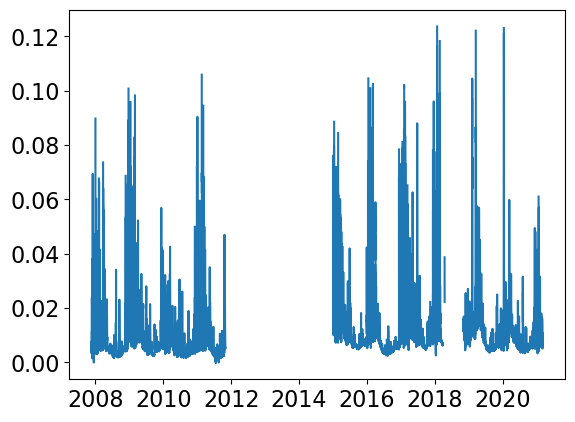

In [ ]:
df = camusto.load_timeseries(data_dir=Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\clean"), basin="HY006", forcing="camusto_1h")

plt.plot(df["discharge(mm)"])

In [82]:
results[catchment]["1h"]

{'xr': <xarray.Dataset>
 Dimensions:            (date: 87696, time_step: 1)
 Coordinates:
   * date               (date) datetime64[ns] 2008-01-01 ... 2018-01-01T23:00:00
   * time_step          (time_step) int64 0
 Data variables:
     discharge(mm)_obs  (date, time_step) float32 0.00533 0.005351 ... 0.009498
     discharge(mm)_sim  (date, time_step) float32 0.007662 0.007662 ... 0.007662,
 'KGE': 0.3571325208105667,
 'NSE': 0.35644370317459106,
 'PI': -1.4650354385375977}

In [38]:

from matplotlib.dates import WeekdayLocator, DateFormatter

import matplotlib.pyplot as plt

# Set font size globally
plt.rcParams.update({'font.size': 16})
tag = "ar"

catchment = "HY123"
if tag == "mts":
    obs = results[catchment]["1h"]["xr"]["discharge(mm)_camusto_1h_obs"].to_dataframe()
    sim = results[catchment]["1h"]["xr"]["discharge(mm)_camusto_1h_sim"].to_dataframe()
else:
    obs = results[catchment]["1h"]["xr"]["discharge(mm)_obs"].to_dataframe()
    sim = results[catchment]["1h"]["xr"]["discharge(mm)_sim"].to_dataframe()

obs = obs.reset_index()
obs['datetime'] = obs['date'] + pd.to_timedelta(obs['time_step'], unit='h')
obs = obs.set_index('datetime').drop(['date', 'time_step'], axis=1)
obs.columns = ["discharge(cms)"]
obs = obs * areas[catchment] / 1000 / 900 # Convert to cms

sim = sim.reset_index()
sim['datetime'] = sim['date'] + pd.to_timedelta(sim['time_step'], unit='h')
sim = sim.set_index('datetime').drop(['date', 'time_step'], axis=1)
sim.columns = ["discharge(cms)"]
sim = sim * areas[catchment] / 1000  / 900# Convert to cms

precip = camusto.load_timeseries(data_dir=Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\clean"), basin=catchment, forcing="camusto_1h")["precipitation(mm)"]

sim, obs = sim.align(obs, join='inner', axis=0)
sim, precip = sim.align(precip, join='inner', axis=0)
sim[sim<0]=0


# Filter data for June and July
june_july_filter = (obs.index.month.isin([6, 7]))
june_july_filter = obs.loc["2013-07-01":"2013-08-31"].index
#june_july_filter = obs.index
# Plot filtered data

for formats in ["wide","narrow","full"]:
    if formats == "wide":
        figsize = (29, 6)
    elif formats == "narrow":
        figsize = (14.5, 12)
    elif formats == "full":
        figsize = (29, 12)
    else:
        raise ValueError("formats must be 'wide', 'narrow', or 'full'")
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(obs.loc[june_july_filter].index, obs.loc[june_july_filter, "discharge(cms)"], label="obs", color="black", linestyle="-", linewidth=4)
    ax.plot(sim.loc[june_july_filter].index, sim.loc[june_july_filter, "discharge(cms)"], label="sim", color="green", linestyle="-", linewidth=2)

    ax2 = ax.twinx()

    ax2.plot(precip.loc[june_july_filter].index, precip.loc[june_july_filter].values, label="precipitation", color="#1f77b4", linestyle="-", linewidth=4, zorder=-1)

    ax2.set_ylabel("Precipitation (mm/hr)")
    ax2.set_ylim(0, 50)  # Set the range of the y-axis to 30
    ax2.invert_yaxis()  # Reverse the y-axis
    ax2.set_xticklabels([])


    perf = Performance(obs=obs.loc[june_july_filter], sim=sim.loc[june_july_filter], high_flow_percentile=0.99)

    plt.title(f"{tag.upper()}-LSTM - catchment {catchment} - observed vs simulated (KGE={perf.kge():.2f})", fontsize=20)
    plt.xlabel("Time")
    ax.set_ylabel("Discharge (cms)")
    #ax.set_ylim(0, 1)  # Set the range of the y-axis to 30
    plt.sca(ax)
    plt.legend(["Obs","Sim"], loc="best", fontsize=14, frameon=False)

    # Set x-axis ticks to every week
    #ax.xaxis.set_major_locator(WeekdayLocator())
    #ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
    # Set daily minor ticks
    #ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=range(7), interval=1))
    # Set minor x-axis ticks

    ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
    ax.set_xlim([obs.loc[june_july_filter].index.min(), obs.loc[june_july_filter].index.max()])
    ax.set_ylim(0,80)
    
    
            # Set x-axis ticks to every week
    ax.xaxis.set_major_locator(WeekdayLocator())
    ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
    # Set daily minor ticks
    ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=range(7), interval=1))
    # Set minor x-axis ticks

    ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=range(7), interval=1))


    plt.grid(which='both', linestyle='--', linewidth=0.5)
    
    
    
    plt.tight_layout()
    plt.show()



    fig.savefig(output_path / f"{tag.upper()}_{catchment}_hydrograph_{formats}.png", dpi=900, bbox_inches="tight")
    fig.clf()


KeyError: 'HY123'